In this script we conduct our exploratory analysis, including constructing neural RDMs and conducting an IS-RSA. We loop over all nodes and then determine which of the 268 exhibit exhibit asynchrony between subjects relative to their identity, ideology, SES, gender and education. The nodes which have a significant difference will then be included in our confirmatory analysis as pre-defined regions of interest (ROIs).

In [14]:
# importing packages

# general
import os

# for data wrangling/management and non-MRI calculations 
import numpy as np
import pandas as pd
import scipy
from scipy.stats import rankdata, ttest_rel, ttest_1samp
import statsmodels.stats.multitest
from joblib import Parallel, delayed
import pickle
from tqdm import tqdm
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from sklearn.manifold import TSNE

# for plotting
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

# for fMRI
import nibabel as nib
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf
from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr, threshold
from nltools import Brain_Data

#import glob
#import datalad.api as dl
#from pathlib import Path
#import seaborn as sns
#from datetime import datetime

%matplotlib inline

# setting work and data directories
csv_directory = os.path.dirname("/home/c13572687/Documents/scripts_and_data/csv_data/") # this on the server
fmri_directory = os.path.dirname("/home/c13572687/Documents/scripts_and_data/fmri_data/") # this on the server

# loading data
exploratory_data = pd.read_csv(str(csv_directory + "/exploratory_half.csv"), sep = ',')
exploratory_data.head()

,participant_id,age,sex,education_level,background_SES,social.ideology,social.ideology.scale,social.identity,social.identity.scale,political.interest,political.interest.scale
0,sub-0734,21.75,female,high,4.0,1.75,0.079403,3,-0.240663,5.333333,0.608898
1,sub-0701,25.75,female,high,6.0,2.00,0.497680,3,-0.240663,1.333333,-1.789575
2,sub-0675,23.25,female,low,3.0,3.25,2.589063,4,0.530098,2.666667,-0.990084
3,sub-0352,20.75,female,high,5.0,1.50,-0.338874,3,-0.240663,NaN,NaN
4,sub-0480,24.75,female,high,4.5,1.00,-1.175427,4,0.530098,4.666667,0.209153


Loading in Shen mask:

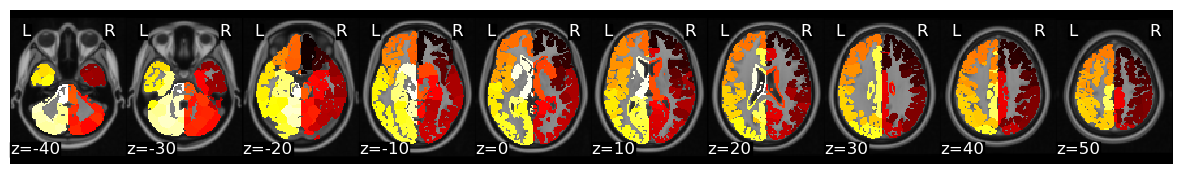

In [15]:
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask.plot()

masker = NiftiLabelsMasker(labels_img=mask.to_nifti(), standardize=False)

We need to load in the data, then per-subject per-run we need to resample and apply the mask, then create a node-wise time series. In the following cell we create a function which does this, and in the cell after we run it for 20 subjects simulatenously.

In [ ]:
subj_list = np.arange(0,len(exploratory_data['participant_id']),1)

def get_ts(subject):
    for run in [1, 2, 3]:
        this_subject = exploratory_data['participant_id'][subject]
        fmri_filename = os.path.join(fmri_directory, exploratory_data['participant_id'][subject], 'func', str(exploratory_data['participant_id'][subject] + '_task-moviewatching_bold.nii.gz'))
        print(f"Creating node time series for {this_subject}, run {run}")
        
        # we need to resample first, then apply the mask
        brain_data = Brain_Data(fmri_filename)
        time_series_fname = os.path.join(fmri_directory, this_subject, 'func', str(f'{this_subject}_run-{run}_nodeTimeSeries.csv'))
        time_series = masker.fit_transform(brain_data.to_nifti())
        pd.DataFrame(time_series).to_csv(time_series_fname, index=False)
    return

Parallel(n_jobs=20)(delayed(get_ts)(subject) for (subject) in subj_list)

In [62]:
def get_ts(subject):
    for run in [1, 2, 3]:
        this_subject = exploratory_data['participant_id'][subject]
        fmri_filename = os.path.join(fmri_directory, exploratory_data['participant_id'][subject], 'func', str(exploratory_data['participant_id'][subject] + '_task-moviewatching_bold.nii.gz'))
        print(f"Creating node time series for {this_subject}, run {run}")
        
        # we need to resample first, then apply the mask
        brain_data = Brain_Data(fmri_filename)
        time_series_fname = os.path.join(fmri_directory, this_subject, 'func', str(f'{this_subject}_run-{run}_nodeTimeSeries.csv'))
        time_series = masker.fit_transform(brain_data.to_nifti())
        pd.DataFrame(time_series).to_csv(time_series_fname, index=False)
    return

In [3]:
??fit_transform

Object `fit_transform` not found.


We now have to add all runs from all subjects into a `numpy` array:

In [22]:
subj_list = np.arange(0,len(exploratory_data['participant_id']),1)
data = []

for subj in tqdm(subj_list):
    this_subject = exploratory_data['participant_id'][subj]
    sub_data = []
    for run in range(1,4):
        current_file = pd.read_csv(os.path.join(fmri_directory, this_subject, 'func', str(f'{this_subject}_run-{run}_nodeTimeSeries.csv')))
        sub_data.append(current_file)
    sub_data = pd.concat(sub_data)
    data.append(sub_data.values)

data = np.array(data)

100%|███████████████████████████████████████████████████████████| 427/427 [00:24<00:00, 17.58it/s]


We should check that we have the correct data structure, which is number of subjects x number of time points across all 3 runs x number of nodes. For our data this should be 427 x 870 x 268.

In [23]:
print(data.shape)
n_subs, n_ts, n_nodes = data.shape

(427, 870, 268)


We will now visualize our similarity matrix and see that it makes sense (i.e., that there are different colours which indicate different correlations between subjects for a particular node):

In [24]:
similarity_matrices = []
for node in range(n_nodes):
    similarity_matrices.append(Adjacency(1 - pairwise_distances(data[:, :, node], metric='correlation'), matrix_type='distance'))
similarity_matrices = Adjacency(similarity_matrices)

saving_directory = os.path.dirname("/home/c13572687/Documents/scripts_and_data/figures/exploratory/")

random_nodes = np.random.randint(0, 267, 3)
for node in random_nodes:
    plt.figure()
    similarity_matrices[node].plot(vmin=-.25, vmax=.25, cmap='RdBu_r')    
    plt.title(str("Visualizing similarity matrix for node " + str(node)))
    plt.savefig(os.path.join(saving_directory + '/RDMs/new/exploratory-RDM-node_' + str(node) + '.png'), dpi = 500)
    plt.show()

Next, we calculate and plot the intersubject synchrony of each of our 268 nodes (where a darker colour indicates a higher synchrony).
Sanity check: early cortical areas (such as the early visual and auditory cortexes) appear to be more synchronous!

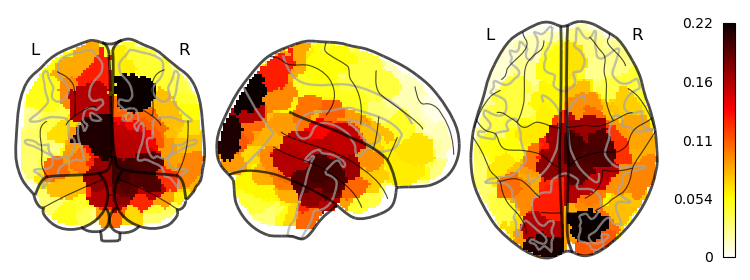

In [77]:
isc = {node:similarity_matrices[node].isc(metric='mean', n_bootstraps=1, n_jobs=1)['isc'] for node in range(n_nodes)}
# isc_p = {node:similarity_matrices[node].isc(metric='mean', n_bootstraps=1, n_jobs=1)['p'] for node in range(n_nodes)}
expand_mask(mask)
isc_brain = roi_to_brain(pd.Series(isc), expand_mask(mask))
plot_glass_brain(isc_brain.to_nifti(), colorbar = True)#, #title = "Mean Correlation Across Subjects")

#plt.savefig(os.path.join(saving_directory + '/brains/synchrony.png'), dpi = 500)
plt.show()

In [80]:
for roi in range(len(isc_p)):
    if isc[roi] >= 0.19:
        print(roi, isc[roi])

74 0.2165209355098011
94 0.19495507157930586
95 0.1942504774601771
102 0.19129280848768518
131 0.19858087238841274
211 0.20962463062786604


In [23]:
directory = os.path.join("Documents/scripts_and_data/numpy_files_analysis/exploratory/")
np.save("isc_exploratory.npy", isc)

Now we'll load our behavioural data and produce RDMs using the Euclidean distance, firstly in a nearest neighbor (NN) model, then in an Anna-K (AK), then a Mahalanobis Distance (MD) model.

In [294]:
variables = np.array(["social.ideology.scale", "social.identity.scale", 
                      "education_level", "background_SES", "sex"])

behav_sims_nn = dict()
for variable in variables:
    behav = exploratory_data[variable][subj_list]
    behav_rank = rankdata(behav) # explicity convert the raw scores to ranks

    behav_sim_nn = Adjacency(pairwise_distances(np.reshape(behav_rank, (-1, 1)), metric='euclidean'), matrix_type='distance')
    behav_sim_nn.distance_to_similarity()
    
    behav_sims_nn[variable] = behav_sim_nn.distance_to_similarity()

    #plt.figure()
    #behav_sim_nn.plot()
    #plt.title(str("Behavioral similarity matrix (NN) \n " + variable), fontsize=12)
    #plt.savefig(os.path.join(saving_directory + '/RDMs/new/exploratory-RDM-NN-' + variable + '.png'), dpi = 500)


In [295]:
behav_sims_annak = dict() # creating dictionary to store matrices

for variable in variables:
    
    behav = exploratory_data[variable][subj_list]
    behav_rank = rankdata(behav) # explicity convert the raw scores to ranks
    
    behav_sim_annak = np.zeros((n_subs, n_subs))

    # calculating Anna-K distance
    for i in range(n_subs):
        for j in range(n_subs):
            if i < j:
                sim_ij = np.mean([behav_rank[i], behav_rank[j]])/n_subs
                behav_sim_annak[i,j] = sim_ij
                behav_sim_annak[j,i] = sim_ij
            elif i==j:
                behav_sim_annak[i,j] = 1

    # plotting and saving in dict
    behav_sim_annak = Adjacency(behav_sim_annak, matrix_type='distance')
    behav_sims_annak[variable] = behav_sim_annak

    #plt.figure()
    #behav_sim_annak.plot()
    #plt.title(str("Behavioral similarity matrix (AK) \n " + variable), fontsize=12)
    #plt.savefig(os.path.join(saving_directory + '/RDMs/new/exploratory-RDM-AK-' + variable + '.png'), dpi = 500)


In [296]:
behav_sims_md = dict() # creating dictionary to store matrices

for variable in variables:
    
    behav = exploratory_data[variable][subj_list]
    behav_rank = rankdata(behav) # explicity convert the raw scores to ranks
    
    behav_sim_md = np.zeros((n_subs, n_subs))
    
    vi = np.cov(np.transpose(behav_rank))
    vi = 1/vi # inverse?
    
    for i in range(n_subs):
        for j in range(n_subs):
            if i < j:
                dist = scipy.spatial.distance.mahalanobis(u = behav_rank[i],
                                                          v = behav_rank[j],
                                                          VI = vi)
                behav_sim_md[i,j] = dist
                behav_sim_md[j,i] = dist
            elif i==j:
                behav_sim_md[i,j] = 1
                                        
    # plotting and saving in dict
    behav_sim_md = Adjacency(behav_sim_md, matrix_type='distance')
    behav_sims_md[variable] = behav_sim_md
                                                        
    #plt.figure()
    #behav_sim_md.plot()
    #plt.title(str("Behavioral similarity matrix (MD) \n " + variable), fontsize=12)
    #plt.savefig(os.path.join(saving_directory + '/RDMs/new/exploratory-RDM-MD-' + variable + '.png'), dpi = 500)
    

Now for the IS-RSA:

In [297]:
isrsa_nn, isrsa_annak, isrsa_md = {}, {}, {}
for node in range(len(similarity_matrices)):
    isrsa_nn[node] = similarity_matrices[node].similarity(behav_sim_nn, metric='spearman', n_permute=1, n_jobs=1 )['correlation']
    isrsa_annak[node] = similarity_matrices[node].similarity(behav_sim_annak, metric='spearman', n_permute=1, n_jobs=1 )['correlation']
    isrsa_md[node] = similarity_matrices[node].similarity(behav_sim_md, metric='spearman', n_permute=1, n_jobs=1 )['correlation']

isrsa_nn_brain = roi_to_brain(pd.Series(isrsa_nn), expand_mask(mask))
isrsa_annak_brain = roi_to_brain(pd.Series(isrsa_annak), expand_mask(mask))
isrsa_md_brain = roi_to_brain(pd.Series(isrsa_md), expand_mask(mask))


<Figure size 640x480 with 0 Axes>

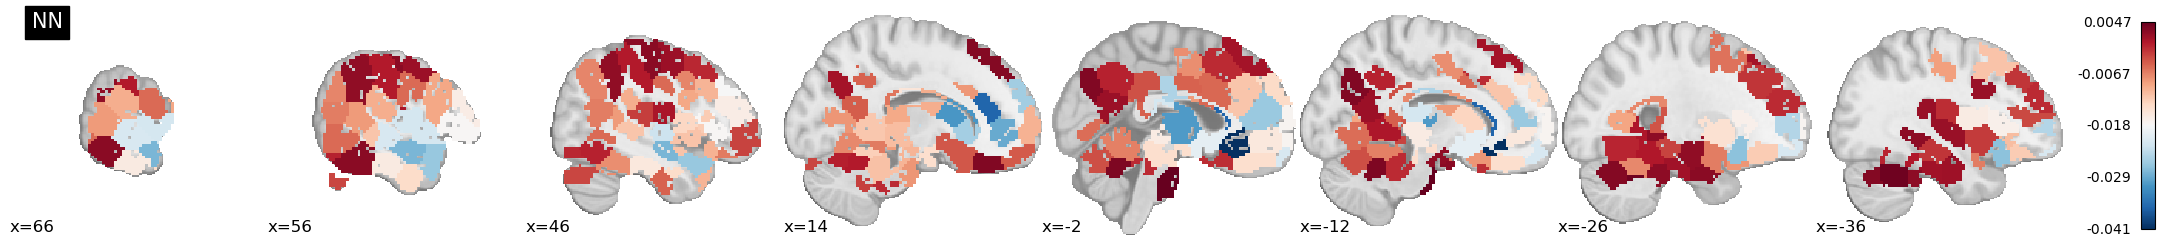

<Figure size 640x480 with 0 Axes>

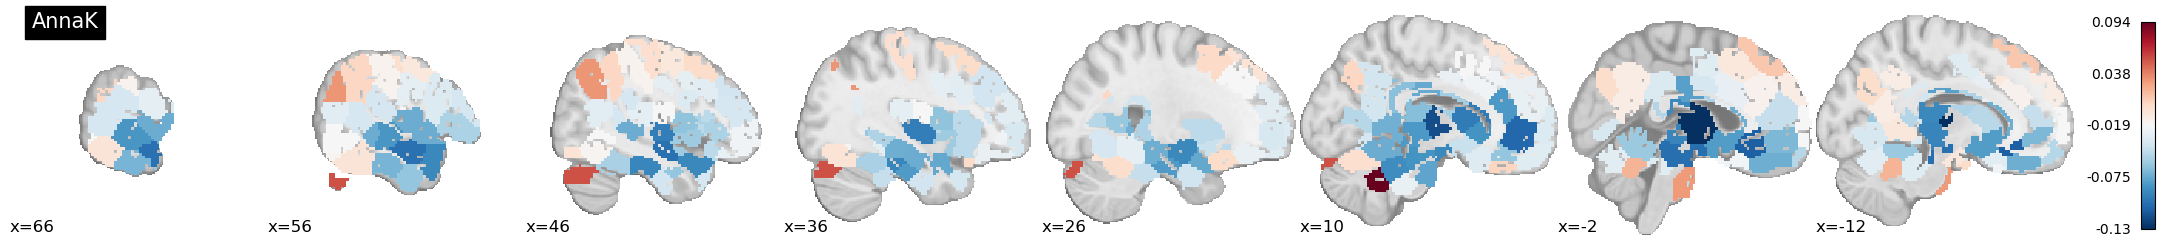

<Figure size 640x480 with 0 Axes>

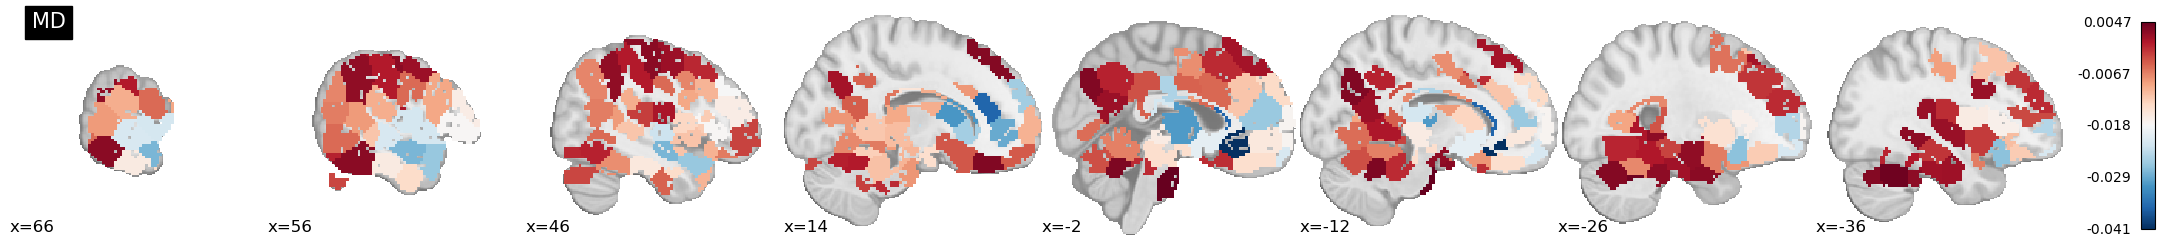

In [300]:
# Find the max absolute magnitude r_val across both sets of results so we can plot using the same colorscale
vmax = np.max(np.abs([list(isrsa_nn.values()), 
                      list(isrsa_annak.values()),
                     list(isrsa_md.values())
                     ]))
plt.figure()
plot_stat_map(isrsa_nn_brain.to_nifti(), display_mode='x', cut_coords=8, vmax=vmax, title = "NN", cmap='RdBu_r')
plt.savefig(os.path.join(saving_directory + '/brains/nn_model_comparison.png'), dpi = 500)

plt.figure()
plot_stat_map(isrsa_annak_brain.to_nifti(), display_mode='x', cut_coords=8, vmax=vmax, title = "AnnaK", cmap='RdBu_r')
plt.savefig(os.path.join(saving_directory + '/brains/annak_model_comparison.png'), dpi = 500)

plt.figure()
plot_stat_map(isrsa_md_brain.to_nifti(), display_mode='x', cut_coords=8, vmax=vmax, title = "MD", cmap='RdBu_r')
plt.savefig(os.path.join(saving_directory + '/brains/md_model_comparison.png'), dpi = 500)


Now onto hypothesis testing!

The next three cells loop over each of our five variables and compares the behavioural score RDM to the neural RDM by creating a null distribution through permuting 10,000 times (Mantel's test). We save the resulting data in one of four dictionaries, which are then saved as files for easy access without having to rerun the entire test. The difference between the dictionaries is whether the data being saved is correlation or _p_-value data, and whether it is nodewise or `nifti` data.

Each cell runs the data from a different distance metric: the first is NN, the second is AK and the third is CDM.

In [ ]:
nifti_saving_dir = os.path.join("/home/c13572687/Documents/scripts_and_data/nifti_files_analysis/")

isrsa_nn_r_dict = dict()
isrsa_nn_r_brain_dict = dict()
isrsa_nn_p_dict = dict()
isrsa_nn_p_brain_dict = dict()

for variable in tqdm(variables):

    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Starting with variable:", variable)
    print("Starting Time =", current_time)

    isrsa_nn_r, isrsa_nn_p = {}, {}
    for node in tqdm(range(len(similarity_matrices))):
        if node==0:
            print("Doing node {} of {}...".format(node+1, len(similarity_matrices)), end =" ")
        else:
            print("{}..".format(node+1), end = " ")
        stats_nn = similarity_matrices[node].similarity(behav_sims_nn[variable], metric='spearman', n_permute=10000, n_jobs=-1 )
        isrsa_nn_r[node] = stats_nn['correlation']
        isrsa_nn_r_dict[variable, node] = stats_nn['correlation']
        isrsa_nn_p[node] = stats_nn['p']
        isrsa_nn_p_dict[variable, node] = stats_nn['p']

    isrsa_nn_r_brain = roi_to_brain(pd.Series(isrsa_nn_r), expand_mask(mask))
    isrsa_nn_p_brain = roi_to_brain(pd.Series(isrsa_nn_p), expand_mask(mask))
    
    isrsa_nn_r_brain_dict[variable] = isrsa_nn_r_brain
    isrsa_nn_p_brain_dict[variable] = isrsa_nn_p_brain
    
    file_name = str("isrsa_nn_r_brain_dict_" + variable + ".nii")
    file_dir = os.path.join(nifti_saving_dir, file_name)
    nib.save(isrsa_nn_r_brain_dict[variable].to_nifti(), file_dir)
    print(file_dir, "saved!")
    
    file_name = str("isrsa_nn_p_brain_dict_" + variable + ".nii")
    file_dir = os.path.join(nifti_saving_dir, file_name)
    nib.save(isrsa_nn_p_brain_dict[variable].to_nifti(), file_dir)
    print(file_dir, "saved!")
    
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Finshing Time =", current_time)
    
np.save('isrsa_nn_r_dict.npy', isrsa_nn_r_dict) 
np.save('isrsa_nn_p_dict.npy', isrsa_nn_p_dict) 


In [ ]:
from datetime import datetime

isrsa_annak_r_dict = dict()
isrsa_annak_r_brain_dict = dict()
isrsa_annak_p_dict = dict()
isrsa_annak_p_brain_dict = dict()

for variable in tqdm(variables):

    isrsa_annak_r, isrsa_annak_p = {}, {}
    for node in tqdm(range(len(similarity_matrices))):
        if node==0:
            print("Doing node {} of {}...".format(node+1, len(similarity_matrices)), end =" ")
        else:
            print("{}..".format(node+1), end = " ")
        stats_annak = similarity_matrices[node].similarity(behav_sims_annak[variable], metric='spearman', n_permute=10000, n_jobs=-1 )
        isrsa_annak_r[node] = stats_annak['correlation']
        isrsa_annak_r_dict[variable, node] = stats_annak['correlation']
        isrsa_annak_p[node] = stats_annak['p']
        isrsa_annak_p_dict[variable, node] = stats_annak['p']

    isrsa_annak_r_brain = roi_to_brain(pd.Series(isrsa_annak_r), expand_mask(mask))
    isrsa_annak_p_brain = roi_to_brain(pd.Series(isrsa_annak_p), expand_mask(mask))
    
    isrsa_annak_r_brain_dict[variable] = isrsa_annak_r_brain
    isrsa_annak_p_brain_dict[variable] = isrsa_annak_p_brain

    file_name = str("isrsa_annak_r_brain_dict_" + variable + ".nii")
    file_dir = os.path.join(nifti_saving_dir, file_name)
    nib.save(isrsa_nn_r_brain_dict[variable].to_nifti(), file_dir)
    print(file_dir, "saved!")
    
    file_name = str("isrsa_annak_p_brain_dict_" + variable + ".nii")
    file_dir = os.path.join(nifti_saving_dir, file_name)
    nib.save(isrsa_nn_p_brain_dict[variable].to_nifti(), file_dir)
    print(file_dir, "saved!")

np.save('isrsa_annak_r_dict.npy', isrsa_annak_r_dict) 
np.save('isrsa_annak_p_dict.npy', isrsa_annak_p_dict) 

In [ ]:
isrsa_md_r_brain_dict = dict()
isrsa_md_r_dict = dict()
isrsa_md_p_brain_dict = dict()
isrsa_md_p_dict = dict()

for variable in tqdm(variables):

    isrsa_md_r, isrsa_md_p = {}, {}
    for node in tqdm(range(len(similarity_matrices))):
        if node==0:
            print("Doing node {} of {}...".format(node+1, len(similarity_matrices)), end =" ")
        else:
            print("{}..".format(node+1), end = " ")
        stats_nn = similarity_matrices[node].similarity(behav_sims_md[variable], metric='spearman', n_permute=10000, n_jobs=-1 )
        isrsa_md_r[node] = stats_nn['correlation']
        isrsa_md_r_dict[variable, node] = stats_annak['correlation']
        isrsa_md_p[node] = stats_nn['p']
        isrsa_md_p_dict[variable, node] = stats_annak['p']

    isrsa_md_r_brain = roi_to_brain(pd.Series(isrsa_md_r), expand_mask(mask))
    isrsa_md_p_brain = roi_to_brain(pd.Series(isrsa_md_p), expand_mask(mask))
    
    isrsa_md_r_brain_dict[variable] = isrsa_md_r_brain
    isrsa_md_p_brain_dict[variable] = isrsa_md_p_brain
    
    file_name = str("isrsa_md_r_brain_dict_" + variable + ".nii")
    file_dir = os.path.join(nifti_saving_dir, file_name)
    nib.save(isrsa_nn_r_brain_dict[variable].to_nifti(), file_dir)
    print(file_dir, "saved!")
    
    file_name = str("isrsa_md_p_brain_dict_" + variable + ".nii")
    file_dir = os.path.join(nifti_saving_dir, file_name)
    nib.save(isrsa_nn_p_brain_dict[variable].to_nifti(), file_dir)
    print(file_dir, "saved!")
    

np.save('isrsa_md_r_dict.npy', isrsa_md_r_dict) 
np.save('isrsa_md_p_dict.npy', isrsa_md_p_dict)


Now that we've finished looping over everything, we can visualize our results (both the correlations and _p_-values).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from nilearn import plotting
cut_coords = (33,-28,15)

saving_directory = os.path.dirname("/home/c13572687/Documents/scripts_and_data/figures/")

for variable in variables:
    print('Nearest-Neighbor Model for', variable)
    plotting.plot_stat_map(isrsa_nn_r_brain_dict[variable].to_nifti(), cut_coords=cut_coords,
                       output_file=os.path.join(saving_directory + '/brains/nn_brain_correlations_' + variable + '.png'))
    
    plotting.plot_stat_map(isrsa_nn_p_brain_dict[variable].to_nifti(), cut_coords=cut_coords,
                       output_file=os.path.join(saving_directory + '/brains/nn_brain_p_vals_' + variable + '.png'))

    print('Anna K Model for', variable)
    plotting.plot_stat_map(isrsa_annak_r_brain_dict[variable].to_nifti(), cut_coords=cut_coords,
                       output_file=os.path.join(saving_directory + '/brains/annak_brain_correlations_' + variable + '.png'))
    
    plotting.plot_stat_map(isrsa_annak_p_brain_dict[variable].to_nifti(), cut_coords=cut_coords,
                       output_file=os.path.join(saving_directory + '/brains/annak_brain_p_vals_' + variable + '.png'))

    print('MD for', variable)
    plotting.plot_stat_map(isrsa_md_r_brain_dict[variable].to_nifti(), cut_coords=cut_coords,
                       output_file=os.path.join(saving_directory + '/brains/md_brain_correlations_' + variable + '.png'))
    
    plotting.plot_stat_map(isrsa_md_p_brain_dict[variable].to_nifti(), cut_coords=cut_coords,
                       output_file=os.path.join(saving_directory + '/brains/md_brain_p_vals_' + variable + '.png'))


In a case where we want to load files (from an analysis we did before), we'll need this cell (make sure to run the first two cells beforehand!):

In [ ]:
variables = np.array(["social.ideology.scale", "social.identity.scale", 
                      "education_level", "background_SES", "sex"])

nifti_loading_dir = os.path.join("/home/c13572687/Documents/scripts_and_data/nifti_files_analysis/exploratory/")

isrsa_nn_r_brain_dict = dict()
isrsa_nn_p_brain_dict = dict()
isrsa_annak_r_brain_dict = dict()
isrsa_annak_p_brain_dict = dict()
isrsa_md_r_brain_dict = dict()
isrsa_md_p_brain_dict = dict()

for variable in tqdm(variables):
    file_name = str(nifti_loading_dir + "isrsa_nn_r_brain_dict_" + variable + ".nii")
    file_dir = os.path.join(nifti_loading_dir, file_name)
    isrsa_nn_r_brain_dict[variable] = Brain_Data(nib.load(file_dir))

    file_name = str(nifti_loading_dir + "isrsa_nn_p_brain_dict_" + variable + ".nii")
    file_dir = os.path.join(nifti_loading_dir, file_name)
    isrsa_nn_p_brain_dict[variable] = Brain_Data(nib.load(file_dir))
    
    file_name = str(nifti_loading_dir + "isrsa_annak_r_brain_dict_" + variable + ".nii")
    file_dir = os.path.join(nifti_loading_dir, file_name)
    isrsa_annak_r_brain_dict[variable] = Brain_Data(nib.load(file_dir))

    file_name = str(nifti_loading_dir + "isrsa_annak_p_brain_dict_" + variable + ".nii")
    file_dir = os.path.join(nifti_loading_dir, file_name)
    isrsa_annak_p_brain_dict[variable] = Brain_Data(nib.load(file_dir))
    
    file_name = str(nifti_loading_dir + "isrsa_cmd_r_brain_dict_" + variable + ".nii")
    file_dir = os.path.join(nifti_loading_dir, file_name)
    isrsa_md_r_brain_dict[variable] = Brain_Data(nib.load(file_dir))

    file_name = str(nifti_loading_dir + "isrsa_cmd_p_brain_dict_" + variable + ".nii")
    file_dir = os.path.join(nifti_loading_dir, file_name)
    isrsa_md_p_brain_dict[variable] = Brain_Data(nib.load(file_dir))

np_loading_dir = os.path.join("/home/c13572687/Documents/scripts_and_data/numpy_files_analysis/exploratory/")
models = np.array(['nn', 'annak', 'md'])
data_types = np.array(['r', 'p'])

correlations_p_vals = dict()

for model in tqdm(models):
    for variable in variables:
        for data_type in data_types:
            correlations_p_vals[model, variable, data_type] = np.load(np_loading_dir + "isrsa_" + model + "_" + data_type + "_dict.npy", allow_pickle=True).item()

print("Done!")


In [26]:
saving_directory = os.path.dirname("/home/c13572687/Documents/scripts_and_data/figures/exploratory/")

for variable in variables: # im working here
    plot_stat_map(isrsa_nn_r_brain_dict[variable].to_nifti(),
                 title = variable + ", NN", 
                 output_file=os.path.join(saving_directory + '/brains/nn_brain_correlations_' + variable + '.png'))
    plot_stat_map(isrsa_annak_r_brain_dict[variable].to_nifti(),
                 title = variable + ", Anna K",
                 output_file=os.path.join(saving_directory + '/brains/annak_brain_correlations_' + variable + '.png'))
    plot_stat_map(isrsa_nn_p_brain_dict[variable].to_nifti(),
                 title = variable + ", NN", 
                 output_file=os.path.join(saving_directory + '/brains/nn_brain_p_vals_' + variable + '.png'))
    plot_stat_map(isrsa_annak_p_brain_dict[variable].to_nifti(),
                 title = variable + ", Anna K", 
                 output_file=os.path.join(saving_directory + '/brains/annak_brain_correlations_' + variable + '.png'))
    

We must correct our p-values for muliple comparison, and we use the Bonferroni-Holm correction:

In [ ]:
bonf_thrs_nn = dict()
for variable in variables:
    b_h_test = statsmodels.stats.multitest.multipletests((np.array(pd.Series(isrsa_nn_p_brain_dict[variable].data))), alpha=0.05, method='holm',  is_sorted=False, returnsorted=False)
    bonf_thrs_nn[variable] = b_h_test[2]
    print(f'Bonf-Holm Threshold: {np.round(bonf_thrs_nn[variable],7)}')

bonf_thrs_annak = dict()
for variable in variables:
    b_h_test = statsmodels.stats.multitest.multipletests((np.array(pd.Series(isrsa_annak_p_brain_dict[variable].data))), alpha=0.05, method='holm',  is_sorted=False, returnsorted=False)
    bonf_thrs_annak[variable] = b_h_test[2]
    print(f'Bonf-Holm Threshold: {np.round(bonf_thrs_annak[variable],7)}')
    
bonf_thrs_md = dict()
for variable in variables:
    b_h_test = statsmodels.stats.multitest.multipletests((np.array(pd.Series(isrsa_md_p_brain_dict[variable].data))), alpha=0.05, method='holm',  is_sorted=False, returnsorted=False)
    bonf_thrs_md[variable] = b_h_test[2]
    print(f'Bonf-Holm Threshold: {np.round(bonf_thrs_md[variable],7)}')


In [ ]:
for variable in variables:
    plot_stats_map(threshold(isrsa_nn_r_brain[variable], 
                             isrsa_nn_p_brain[variable], 
                             thr=bonf_thrs_nn[variable]).to_nifti(), title = variable)
    
for variable in variables:
    plot_stats_map(threshold(isrsa_annak_r_brain[variable], 
                             isrsa_annak_p_brain[variable], 
                             thr=bonf_thrs_annak[variable]).to_nifti(), title = variable)
    
for variable in variables:
    plot_stats_map(threshold(isrsa_md_r_brain[variable], 
                             isrsa_md_p_brain[variable], 
                             thr=bonf_thrs_md[variable]).to_nifti(), title = variable)